# *****IMPORTING LIBRARIES*****

In [24]:
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr


# *****IMAGE PRE-PROCESSING*****

In [25]:
def apply_gamma_correction(img, gamma):
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(img, table)

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, low_image_paths, high_image_paths, transform=None, gamma=None):
        self.low_image_paths = low_image_paths
        self.high_image_paths = high_image_paths
        self.transform = transform
        self.gamma = gamma
        assert len(self.low_image_paths) == len(self.high_image_paths), "Low and High image directories must contain the same number of images."

    def gamma_correction(self, image, gamma=1.0):
        inv_gamma = 1.0 / gamma
        table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(0, 256)]).astype("uint8")
        return cv2.LUT(image, table)

    def __len__(self):
        return len(self.low_image_paths)

    def __getitem__(self, idx):
        low_img_path = self.low_image_paths[idx]
        high_img_path = self.high_image_paths[idx]
        low_image = cv2.imread(low_img_path)
        high_image = Image.open(high_img_path).convert('RGB')

        if low_image is None:
            raise ValueError(f"Low image at index {idx} not found or unable to load.")
        if self.gamma:
            low_image = self.gamma_correction(low_image, self.gamma)
        low_image = Image.fromarray(low_image)

        if self.transform:
            low_image = self.transform(low_image)
            high_image = self.transform(high_image)

        return low_image, high_image

# ***RESIDUAL-BLOCK CLASS***

In [26]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
        self.skip_bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        residual = self.skip_bn(self.skip(x))

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += residual
        out = self.relu(out)

        return out

# ***DOWNSAMPLING***

In [27]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.pool = nn.MaxPool2d(2)
        self.residual_block = ResidualBlock(in_channels, out_channels)

    def forward(self, x):
        x = self.pool(x)
        return self.residual_block(x)

# ***UPSAMPLING***

In [28]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.residual_block = ResidualBlock(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.residual_block(x)

**OUTERMOST LAYER**

In [29]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


# **U-NET CLASS**

In [30]:
class DeeperUNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(DeeperUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.inc = ResidualBlock(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)  
        self.down5 = Down(1024, 2048)  
        self.up1 = Up(2048, 1024) 
        self.up2 = Up(1024, 512) 
        self.up3 = Up(512, 256)  
        self.up4 = Up(256, 128)  
        self.up5 = Up(128, 64) 
        self.outc = OutConv(64, n_classes)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x6 = self.down5(x5)
        x = self.up1(x6, x5)
        x = self.up2(x, x4)
        x = self.up3(x, x3)
        x = self.up4(x, x2)
        x = self.up5(x, x1)
        logits = self.outc(x)
        return torch.sigmoid(logits)

# ***DATASET PATHS***

In [31]:
train_low_image_directory = '/kaggle/input/loldataset-2/LOLdataset/our485/low'
train_high_image_directory = '/kaggle/input/loldataset-2/LOLdataset/our485/high'
eval_low_image_directory = '/kaggle/input/loldataset-2/LOLdataset/eval15/low'
eval_high_image_directory = '/kaggle/input/loldataset-2/LOLdataset/eval15/high'

****IMAGE PATHS LISTING****

In [32]:
train_low_image_paths = [os.path.join(train_low_image_directory, img) for img in os.listdir(train_low_image_directory) if img.endswith('.png')]
train_high_image_paths = [os.path.join(train_high_image_directory, img) for img in os.listdir(train_high_image_directory) if img.endswith('.png')]

eval_low_image_paths = [os.path.join(eval_low_image_directory, img) for img in os.listdir(eval_low_image_directory) if img.endswith('.png')]
eval_high_image_paths = [os.path.join(eval_high_image_directory, img) for img in os.listdir(eval_high_image_directory) if img.endswith('.png')]

# ******LOADING THE DATA******

In [33]:
gamma_value = 2.2


transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

# Datasets and DataLoaders
train_dataset = CustomDataset(train_low_image_paths, train_high_image_paths, transform=transform, gamma=gamma_value)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

eval_dataset = CustomDataset(eval_low_image_paths, eval_high_image_paths, transform=transform, gamma=gamma_value)
eval_loader = DataLoader(eval_dataset, batch_size=4, shuffle=False)

***SCHEDULING AND OPTIMIZATION***

In [34]:
num_models = 5
models = [DeeperUNet(n_channels=3, n_classes=3).cuda() for _ in range(num_models)]
criterion = nn.MSELoss()
optimizers = [optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4) for model in models]
schedulers = [optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5) for optimizer in optimizers]


# ****TRAINING FUNCTION****

In [35]:
def train(model, criterion, optimizer, loader, scaler, accumulation_steps=1, max_norm=1.0):
    model.train()
    running_loss = 0.0
    optimizer.zero_grad()

    for i, (low, high) in enumerate(loader):
        low = low.cuda()
        high = high.cuda()

        with torch.cuda.amp.autocast():
            outputs = model(low)
            loss = criterion(outputs, high) / accumulation_steps

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        running_loss += loss.item() * accumulation_steps

    epoch_loss = running_loss / len(loader)
    return epoch_loss

# ****EVALUATION FUNCTION****

In [36]:
def evaluate(model, criterion, loader):
    model.eval()
    running_loss = 0.0
    psnr_list = []

    with torch.no_grad():
        for low, high in loader:
            low = low.cuda()
            high = high.cuda()

            outputs = model(low)
            loss = criterion(outputs, high)
            running_loss += loss.item()

            outputs = outputs.permute(0, 2, 3, 1).cpu().numpy()
            high = high.permute(0, 2, 3, 1).cpu().numpy()

            for i in range(outputs.shape[0]):
                output_img = outputs[i]
                output_img = (output_img * 255).astype(np.uint8)
                
                high_img = high[i] * 255

                output_img = cv2.resize(output_img, (high_img.shape[1], high_img.shape[0]))

                output_img = output_img / 255.0
                psnr_value = psnr(high_img / 255.0, output_img, data_range=1.0)
                psnr_list.append(psnr_value)

    avg_psnr = np.mean(psnr_list) if psnr_list else 0.0
    return running_loss / len(loader), avg_psnr

# *****TRAINING LOOP*****

In [37]:
num_epochs = 35
scaler = torch.cuda.amp.GradScaler()

all_psnr_values = [] 
for epoch in range(num_epochs):
    train_losses = []
    for model, optimizer in zip(models, optimizers):
        train_loss = train(model, criterion, optimizer, train_loader, scaler, accumulation_steps=1, max_norm=1.0)
        train_losses.append(train_loss)

    avg_train_loss = np.mean(train_losses)

    val_losses = []
    psnr_values = []
    for model in models:
        val_loss, avg_psnr = evaluate(model, criterion, eval_loader)
        val_losses.append(val_loss)
        psnr_values.append(avg_psnr)

    all_psnr_values.append(psnr_values[np.argmin(val_losses)])

    best_model_idx = np.argmin(val_losses)
    val_loss = val_losses[best_model_idx]

    print(f"Epoch [{epoch+1}/{num_epochs}] - Avg Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, PSNR: {psnr_values[best_model_idx]:.4f}")

    for scheduler, val_loss in zip(schedulers, val_losses):
        scheduler.step(val_loss)

avg_epoch_psnr = np.mean(all_psnr_values) if all_psnr_values else 0.0
print(f"Average PSNR over {num_epochs} epochs: {avg_epoch_psnr:.4f}")


Epoch [1/35] - Avg Train Loss: 0.0220, Val Loss: 0.0159, PSNR: 19.4937
Epoch [2/35] - Avg Train Loss: 0.0161, Val Loss: 0.0167, PSNR: 19.4964
Epoch [3/35] - Avg Train Loss: 0.0147, Val Loss: 0.0132, PSNR: 20.3877
Epoch [4/35] - Avg Train Loss: 0.0141, Val Loss: 0.0129, PSNR: 20.3332
Epoch [5/35] - Avg Train Loss: 0.0135, Val Loss: 0.0120, PSNR: 21.0747
Epoch [6/35] - Avg Train Loss: 0.0130, Val Loss: 0.0114, PSNR: 20.6780
Epoch [7/35] - Avg Train Loss: 0.0123, Val Loss: 0.0113, PSNR: 20.9907
Epoch [8/35] - Avg Train Loss: 0.0120, Val Loss: 0.0114, PSNR: 20.6495
Epoch [9/35] - Avg Train Loss: 0.0113, Val Loss: 0.0102, PSNR: 20.9953
Epoch [10/35] - Avg Train Loss: 0.0111, Val Loss: 0.0091, PSNR: 21.7368
Epoch [11/35] - Avg Train Loss: 0.0111, Val Loss: 0.0095, PSNR: 21.5262
Epoch [12/35] - Avg Train Loss: 0.0107, Val Loss: 0.0109, PSNR: 21.2292
Epoch [13/35] - Avg Train Loss: 0.0105, Val Loss: 0.0102, PSNR: 21.1955
Epoch [14/35] - Avg Train Loss: 0.0098, Val Loss: 0.0100, PSNR: 21.4926
E

 # ***GRAPH PLOT***

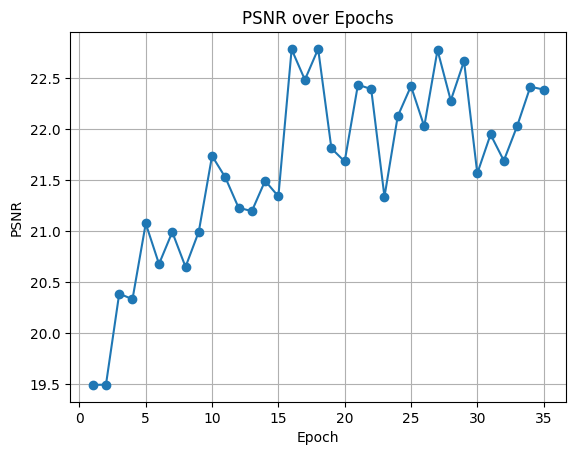

In [38]:
import matplotlib.pyplot as plt

# Plot PSNR values over epochs
plt.plot(range(1, num_epochs+1), all_psnr_values, marker='o')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR over Epochs')
plt.grid(True)
plt.show()


# ***ENHANCING TEST IMAGE***

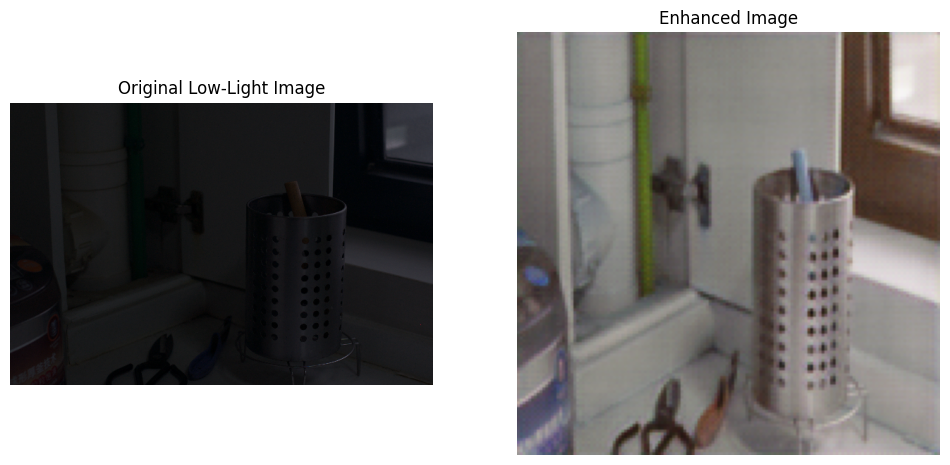

In [42]:
import matplotlib.pyplot as plt
def apply_gamma_correction(img_np, gamma):
    inv_gamma = 1.0 / gamma
    table = (torch.arange(0, 256, dtype=torch.float32) / 255.0) ** inv_gamma * 255
    table = table.clamp(0, 255).byte().cpu().numpy()
    img_np = cv2.LUT(img_np, table)
    return img_np


def enhance_image(model, image_path, transform, gamma=None):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    
    if gamma:
        image_np = np.array(image)
        image_np = apply_gamma_correction(image_np, gamma)
        image = Image.fromarray(image_np)
    
    image = transform(image).unsqueeze(0).cuda()
    
    with torch.no_grad():
        enhanced_image = model(image).squeeze(0).cpu()
    return transforms.ToPILImage()(enhanced_image)
# Path to a sample low-light image
sample_image_path = '/kaggle/input/loldataset-2/LOLdataset/eval15/low/111.png'
# Enhance the image using the best model
best_model = models[best_model_idx]  # Assuming best_model_idx is determined from the training process
enhanced_image = enhance_image(best_model, sample_image_path, transform, gamma=gamma_value)
# Display the original and enhanced images
original_image = Image.open(sample_image_path).convert('RGB')
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Low-Light Image")
plt.imshow(original_image)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Enhanced Image")
plt.imshow(enhanced_image)
plt.axis('off')
plt.show()

# *****EVALUATING BY SAMPLE IMAGE*****

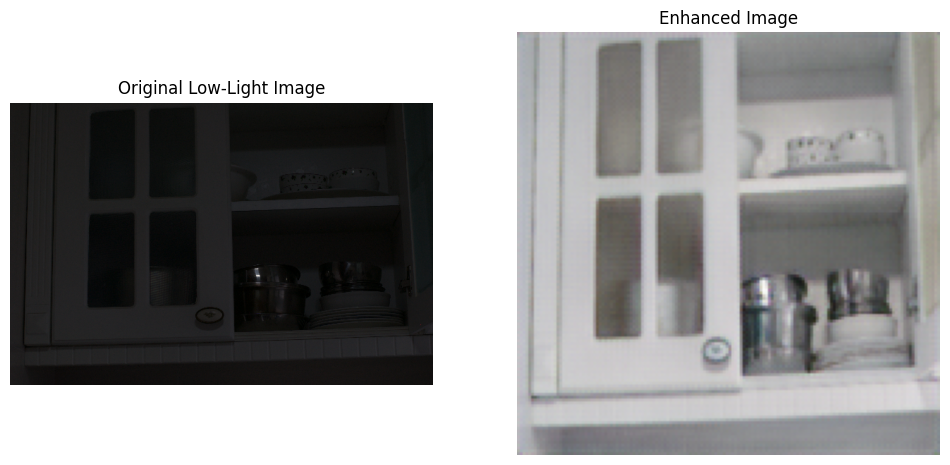

PSNR for the test image: 27.5571


In [43]:
import matplotlib.pyplot as plt

def enhance_image(model, image_path, transform, gamma=None):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    
    if gamma:
        image_np = np.array(image)
        image_np = apply_gamma_correction(image_np, gamma)
        image = Image.fromarray(image_np)
    
    image = transform(image).unsqueeze(0).cuda()
    
    with torch.no_grad():
        enhanced_image = model(image).squeeze(0).cpu()
    
    return transforms.ToPILImage()(enhanced_image), enhanced_image

def apply_gamma_correction(img_np, gamma):
    inv_gamma = 1.0 / gamma
    table = (torch.arange(0, 256, dtype=torch.float32) / 255.0) ** inv_gamma * 255
    table = table.clamp(0, 255).byte().cpu().numpy()
    img_np = cv2.LUT(img_np, table)
    return img_np

def calculate_psnr(original, enhanced):
    original_np = np.array(original)
    enhanced_np = np.array(enhanced)
    return psnr(original_np, enhanced_np)

# Path to a sample low-light image and corresponding high-light image
sample_low_image_path = '/kaggle/input/loldataset-2/LOLdataset/eval15/low/79.png'
sample_high_image_path = '/kaggle/input/loldataset-2/LOLdataset/eval15/high/79.png'

# Enhance the image using the best model
best_model = models[best_model_idx]  # Assuming best_model_idx is determined from the training process
enhanced_image_pil, enhanced_image_tensor = enhance_image(best_model, sample_low_image_path, transform, gamma=gamma_value)

# Calculate PSNR
original_high_image = Image.open(sample_high_image_path).convert('RGB').resize((150, 150))
image_high_tensor = transform(original_high_image).unsqueeze(0)
enhanced_image_np = enhanced_image_tensor.permute(1, 2, 0).numpy()
image_high_np = image_high_tensor.squeeze(0).permute(1, 2, 0).numpy()
psnr_value = calculate_psnr(image_high_np, enhanced_image_np)

# Display the original and enhanced images
original_image = Image.open(sample_low_image_path).convert('RGB')

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Low-Light Image")
plt.imshow(original_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Enhanced Image")
plt.imshow(enhanced_image_pil)
plt.axis('off')

plt.show()

print(f"PSNR for the test image: {psnr_value:.4f}")
